<a href="https://colab.research.google.com/github/DhanyaReji13/ML_Project/blob/main/Rossmann_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rossmann Sales Prediction

##Business Problem
Rossmann operates over 3000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

By July 2015, the main aim of this project was to predict sales for each 1115 stores daily and the Sales data available on Kaggle.

**Rossmann Store Sales Prediction Project – Summary**
###Objective:

Predict daily sales for Rossmann stores using historical sales, store information, promotions, and external factors such as competition and holidays.

###Data Overview:

**Training Data**:

Historical daily sales data for multiple Rossmann stores

- Features included: Store, Date, Sales, Promo, StateHoliday, SchoolHoliday, etc.

**Store Data**:

Static information about stores, such as StoreType, Assortment, and CompetitionDistance

**Test Data:**
Similar structure as training data, without Sales column



**Feature Engineering**: Added flags: HasCompetition, HasPromo2

**Created dummy variables for categorical features**: StateHoliday, StoreType, Assortment

**Train/Test Alignment**: Ensured that test features matched training features for correct prediction.

**Modeling Approach:**

Models Tried:

1. Linear Regression

2. Random Forest Regressor

3. XGBoost Regressor

**Evaluation Metric:**

RMSE (Root Mean Squared Error) — used to compare model performance

**Model Selection:**

XGBoost performed best with validation RMSE ≈ 1152

Further tuning improved performance to RMSE ≈ 1077 on validation

**Hyperparameter Tuning:**

Used domain knowledge and iterative tuning (RandomizedSearchCV optional)

**Key XGBoost hyperparameters tuned:**

n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight

**Final Training:**

Trained the final XGBoost model on the full training dataset (train + validation combined)

Target variable was log-transformed (log1p) to stabilize variance

Final RMSE on training data: ~971

**Test Predictions:**

Preprocessed test dataset in the same way as training

Ensured test columns matched training columns

Predicted daily sales using the trained model

Reversed log-transform using np.expm1

Generated submission CSV with columns: Id and Sales

**Key Learnings:**

Feature engineering is crucial — flags like HasCompetition and HasPromo2 improved predictions

Tree-based models like XGBoost handle non-linear relationships and categorical features well

Always ensure training and test features align exactly before prediction

Log-transforming the target can help reduce the effect of outliers in sales

In [ ]:
#Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

**About this file**

Rossmann historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

**Files**

train.csv - historical data including Sales
test.csv - historical data excluding Sales
sample_submission.csv - a sample submission file in the correct format
store.csv - supplemental information about the stores
Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing the dataset
store_df = pd.read_csv('/content/drive/MyDrive/ML_Rossmann_project/store.csv')
train_df = pd.read_csv('/content/drive/MyDrive/ML_Rossmann_project/train.csv',low_memory=False)
test_df = pd.read_csv('/content/drive/MyDrive/ML_Rossmann_project/train.csv',low_memory=False)

In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:

train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:

test_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


##Explanatory Data Analysis(EDA)

###Data Preprocessing

Date Features: Extracted Year, Month, Day, DayOfWeek from Date.

Handling Missing Values: Filled missing values in CompetitionOpenSinceMonth/Year and Promo2SinceWeek/Year with 0 or median values.

In [ ]:
#Printing the shape of each dataset
print(f"Numberof rows in stores dataset : {store_df.shape[0]} , Numberof columns in stores dataset : {store_df.shape[1]}")
print(f"Numberof rows in train dataset : {train_df.shape[0]} , Numberof columns in train dataset : {train_df.shape[1]}")
print(f"Numberof rows in test dataset : {test_df.shape[0]} , Numberof columns in test dataset : {test_df.shape[1]}")

Numberof rows in stores dataset : 1115 , Numberof columns in stores dataset : 10
Numberof rows in train dataset : 1017209 , Numberof columns in train dataset : 9
Numberof rows in test dataset : 1017209 , Numberof columns in test dataset : 9


In [ ]:
#Checking for missing values
train_df.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0


In [ ]:
#Checking the data types
train_df.dtypes

,0
Store,int64
DayOfWeek,int64
Date,object
Sales,int64
Customers,int64
Open,int64
Promo,int64
StateHoliday,object
SchoolHoliday,int64


Date column and State holiday are  object type.

In [ ]:
#Converting the date column to date type
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [ ]:
#Extracting day,month and year from date column
train_df['Day'] = train_df['Date'].dt.day
train_df['Month'] = train_df['Date'].dt.month
train_df['Year'] = train_df['Date'].dt.year

In [ ]:

print("Distinct values in Store : ",train_df['Store'].unique())
print("Distinct values in StateHoliday : ",train_df['StateHoliday'].unique())
print("Distinct values in SchoolHoliday : ",train_df['SchoolHoliday'].unique())
print("Distinct values in Open : ",train_df['Open'].unique())
print("Distinct values in Promo : ",train_df['Promo'].unique())

Distinct values in Store :  [   1    2    3 ... 1113 1114 1115]
Distinct values in StateHoliday :  ['0' 'a' 'b' 'c']
Distinct values in SchoolHoliday :  [1 0]
Distinct values in Open :  [1 0]
Distinct values in Promo :  [1 0]


In [ ]:
#Creating a new column 'Average sales generated per customer'
train_df['SalesPerCustomer'] = train_df['Sales']/train_df['Customers']

High value → customers are spending more per visit

Low value → customers buy less per visit

Helps distinguish:
*   High traffic vs
*   High-value customers





In [ ]:
#Checking the data set when store was closed
train_closed = train_df[train_df['Open'] == 0]
train_closed.shape

(172817, 13)

The store was closed for 172817 times.This data dont make sense for the sale prediction.

In [ ]:
train_closed[train_closed['Sales']!=0].shape

(0, 13)

In [ ]:
#Dataset when the store is open and checking the number of rows when sales is 0
train_opened = train_df[train_df['Open'] == 1]
train_opened[train_opened['Sales']==0].shape

(54, 13)

The store had 0 sale for 54 open day.These are logically wrong data.

In [ ]:
train_open = train_opened[train_opened['Sales']>0]
train_open.shape

(844338, 13)

In [ ]:
#Understanding the spread of numerical columns
train_open[['Sales', 'Customers','SalesPerCustomer']].describe()

,Sales,Customers,SalesPerCustomer
count,844338.000000,844338.000000,844338.000000
mean,6955.959134,762.777166,9.493641
std,3103.815515,401.194153,2.197448
min,46.000000,8.000000,2.749075
25%,4859.000000,519.000000,7.895571
50%,6369.000000,676.000000,9.250000
75%,8360.000000,893.000000,10.899729
max,41551.000000,7388.000000,64.957854


The Maximum Sales are very high (right skewed) becuase some day the number of customers are very high and therefore average Sales per Customer is also high.

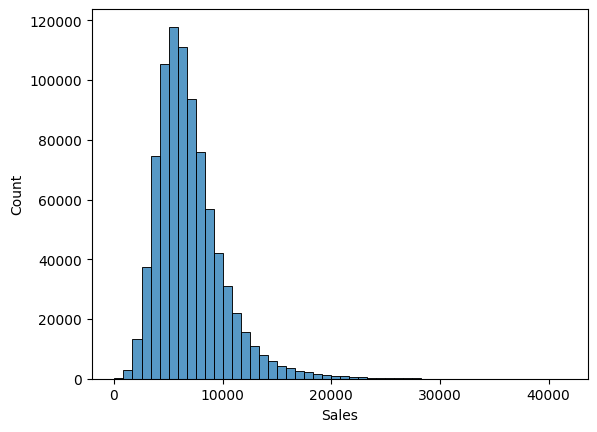

In [ ]:
sns.histplot(train_open['Sales'],bins = 50)
plt.show()

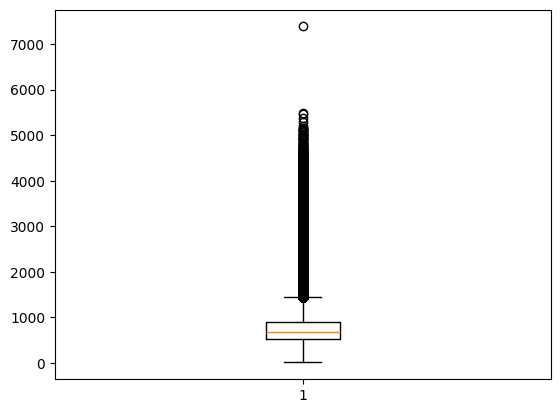

In [ ]:
plt.boxplot(train_open['Customers'])
plt.show()

The Customers variable shows a right-skewed distribution with a median around 600. The interquartile range indicates that most store-days receive between 400 and 800 customers. A large number of high-end outliers reflect peak days driven by promotions, holidays, or store-specific factors rather than data quality issues.

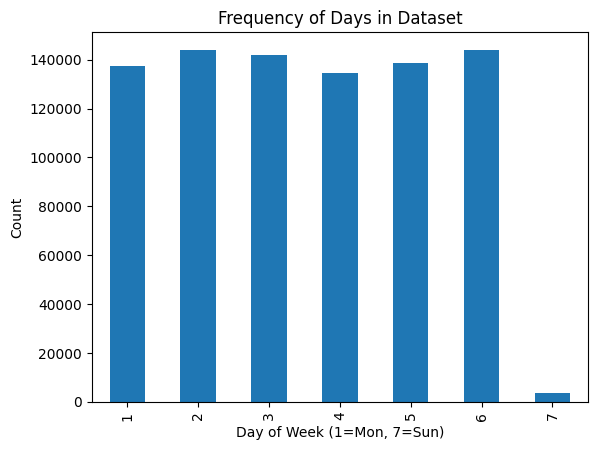

In [ ]:
#Frequency of days in Dataset
train_open['DayOfWeek'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Day of Week (1=Mon, 7=Sun)')
plt.ylabel('Count')
plt.title('Frequency of Days in Dataset')
plt.show()

Some stores were opened on some sunday.The frequency of all the weekdays are similar with Saturday showing the highest peak a slight dip on Thursday

DayOfWeek
1    8216.252259
2    7088.409086
3    6728.786679
4    6768.214973
5    7073.034133
6    5875.084935
7    8224.723908
Name: Sales, dtype: float64


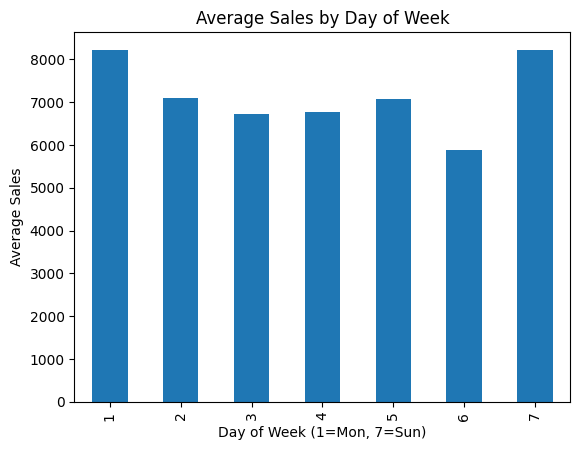

In [ ]:
# Average daily sales by day of the week
print(train_open.groupby('DayOfWeek')['Sales'].mean())
avg_sales = train_open.groupby('DayOfWeek')['Sales'].mean()

avg_sales.plot(kind='bar')
plt.xlabel('Day of Week (1=Mon, 7=Sun)')
plt.ylabel('Average Sales')
plt.title('Average Sales by Day of Week')
plt.show()


Average sales vary significantly by day of the week, with peaks on Monday and Sunday and the lowest sales on Saturday. This confirms strong weekly seasonality, making DayOfWeek an important feature for sales prediction models.

In [ ]:
#Promo vs Sales
train_open.groupby('Promo')['Sales'].mean()

,Sales
Promo,
0,5929.826183
1,8228.739731


In [ ]:
#Count of holidays Vs non holiday
train_df.groupby('SchoolHoliday')['Sales'].mean()


,Sales
SchoolHoliday,
0,5620.979034
1,6476.522207


In [ ]:
#Count of state holiday Vs non state holiday
train_open.groupby('StateHoliday')['Sales'].mean()


,Sales
StateHoliday,
0,6953.960229
a,8487.471182
b,9887.889655
c,9743.746479


**Overall summary**

Promotions have the strongest impact on sales, leading to a substantial increase in average daily revenue. State holidays, especially festive periods like Easter and Christmas, also significantly boost sales, while school holidays show a smaller but positive effect. These findings highlight the importance of including promotion and holiday-related features in the sales forecasting model.

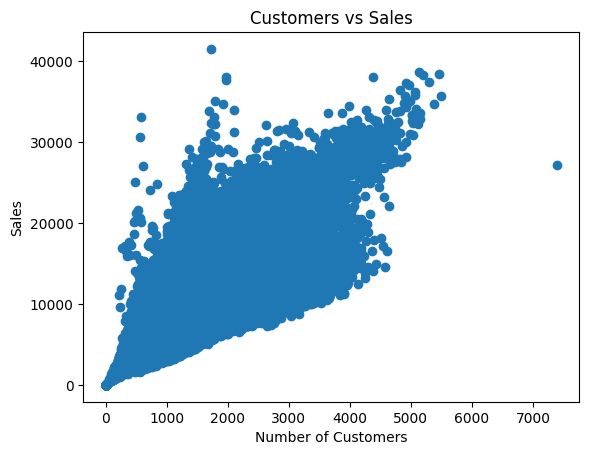

In [ ]:
plt.scatter(train_df['Customers'],train_df['Sales'])
plt.xlabel('Number of Customers')
plt.ylabel('Sales')
plt.title('Customers vs Sales')
plt.show()

Sales increase strongly with customer footfall, though per-customer spending varies.

Year
2013    2302876084
2014    2180804896
2015    1389499643
Name: Sales, dtype: int64


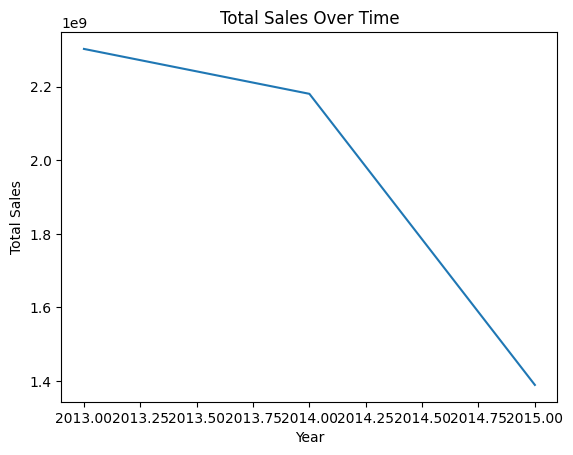

In [ ]:
yearly_sales = train_open.groupby('Year')['Sales'].sum()
print(yearly_sales)

plt.plot(yearly_sales)
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time')
plt.show()

Total sales appear to decline across years, with 2013 showing the highest sales and 2015 the lowest. However, this trend is influenced by incomplete data for 2015, so the focus should remain on daily sales patterns rather than yearly aggregates.

Month
1     367884994
2     350458952
3     394200223
4     377976409
5     380104320
6     370749402
7     382736589
8     361791202
9     342570131
10    351878728
11    369498877
12    433831153
Name: Sales, dtype: int64


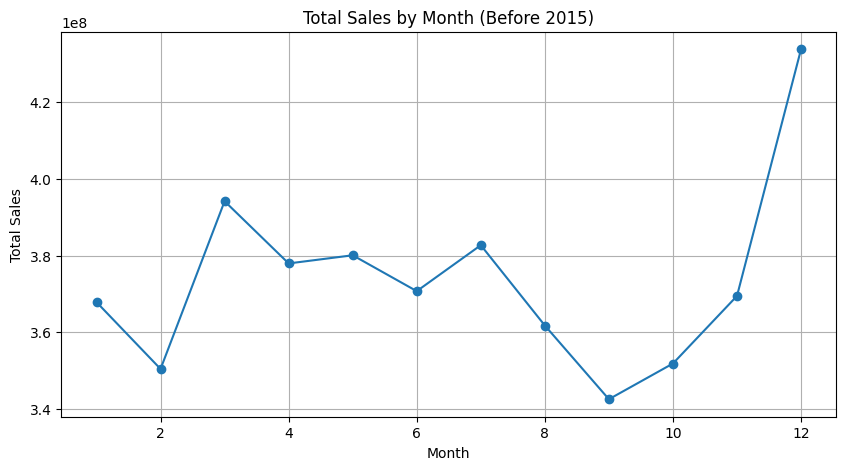

In [ ]:
# Filter data before 2015
train_before_2015 = train_open[train_open['Year'] < 2015]

# Monthly sales aggregation
monthly_sales = train_before_2015.groupby('Month')['Sales'].sum()

print(monthly_sales)

plt.figure(figsize=(10, 5))
monthly_sales.plot(marker='o')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month (Before 2015)')
plt.grid(True)
plt.show()


1.  High-revenue months: March, July, December
2.   Low-revenue months: February, September

Pricing, promotions, and inventory strategies can be optimized based on these patterns.

Sales exhibit strong seasonality, peaking in December and dipping around September, indicating year-end demand surges and late-summer slowdowns.

In [ ]:
print("Distinct values in store : ",store_df['Store'].unique())
print("Distinct values in store type : ",store_df['StoreType'].unique())
print("Distinct values in Promo2 : ",store_df['Promo2'].unique())
print("Distinct values in Assortment : ",store_df['Assortment'].unique())
print("Distinct values in PromoInterval : ",store_df['PromoInterval'].unique())

Distinct values in store :  [   1    2    3 ... 1113 1114 1115]
Distinct values in store type :  ['c' 'a' 'd' 'b']
Distinct values in Promo2 :  [0 1]
Distinct values in Assortment :  ['a' 'c' 'b']
Distinct values in PromoInterval :  [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


<Axes: >

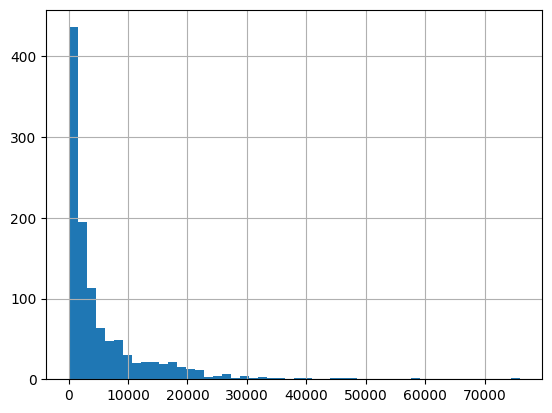

In [ ]:
store_df['CompetitionDistance'].hist(bins = 50)

In [ ]:
#Determining median of the Distance from competitor store
median_dist = store_df['CompetitionDistance'].median()

In [ ]:
#Handling missing values with median
store_df['CompetitionDistance'] = store_df['CompetitionDistance'].fillna(median_dist)

Since competitor Distance is a right skewed data, imputing the missing values with median is the best approach.

In [ ]:
#Checking the store dataset for null values.
store_df.isnull().sum()

,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,0
CompetitionOpenSinceMonth,354
CompetitionOpenSinceYear,354
Promo2,0
Promo2SinceWeek,544
Promo2SinceYear,544
PromoInterval,544


In [ ]:
#Handling the missing values
store_df = store_df.fillna(0)
store_df.isnull().sum()

,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,0
CompetitionOpenSinceMonth,0
CompetitionOpenSinceYear,0
Promo2,0
Promo2SinceWeek,0
Promo2SinceYear,0
PromoInterval,0


In [ ]:
#Merging the train and store data for further analysis
df = train_open.merge(store_df,on ='Store',how = "left")
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,31,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,31,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,31,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,31,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,31,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [ ]:
#Checking missing values
df.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
Day,0


In [ ]:
#Getting the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  object        
 8   SchoolHoliday              844338 non-null  int64         
 9   Day                        844338 non-null  int32         
 10  Month                      844338 non-null  int32         
 11  Year                       844338 non-null  int32   

<Axes: xlabel='StoreType', ylabel='Sales'>

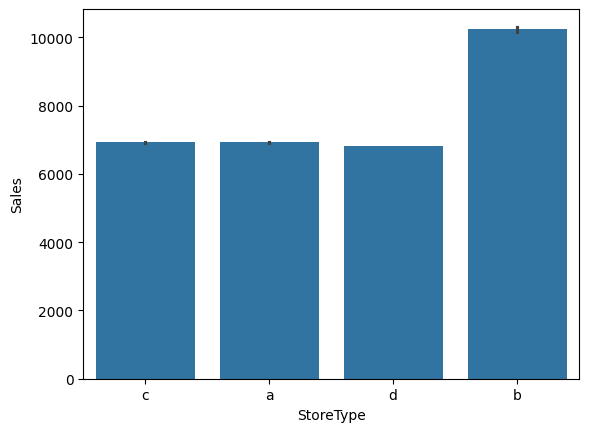

In [ ]:
sns.barplot(x= 'StoreType',y='Sales',data = df)

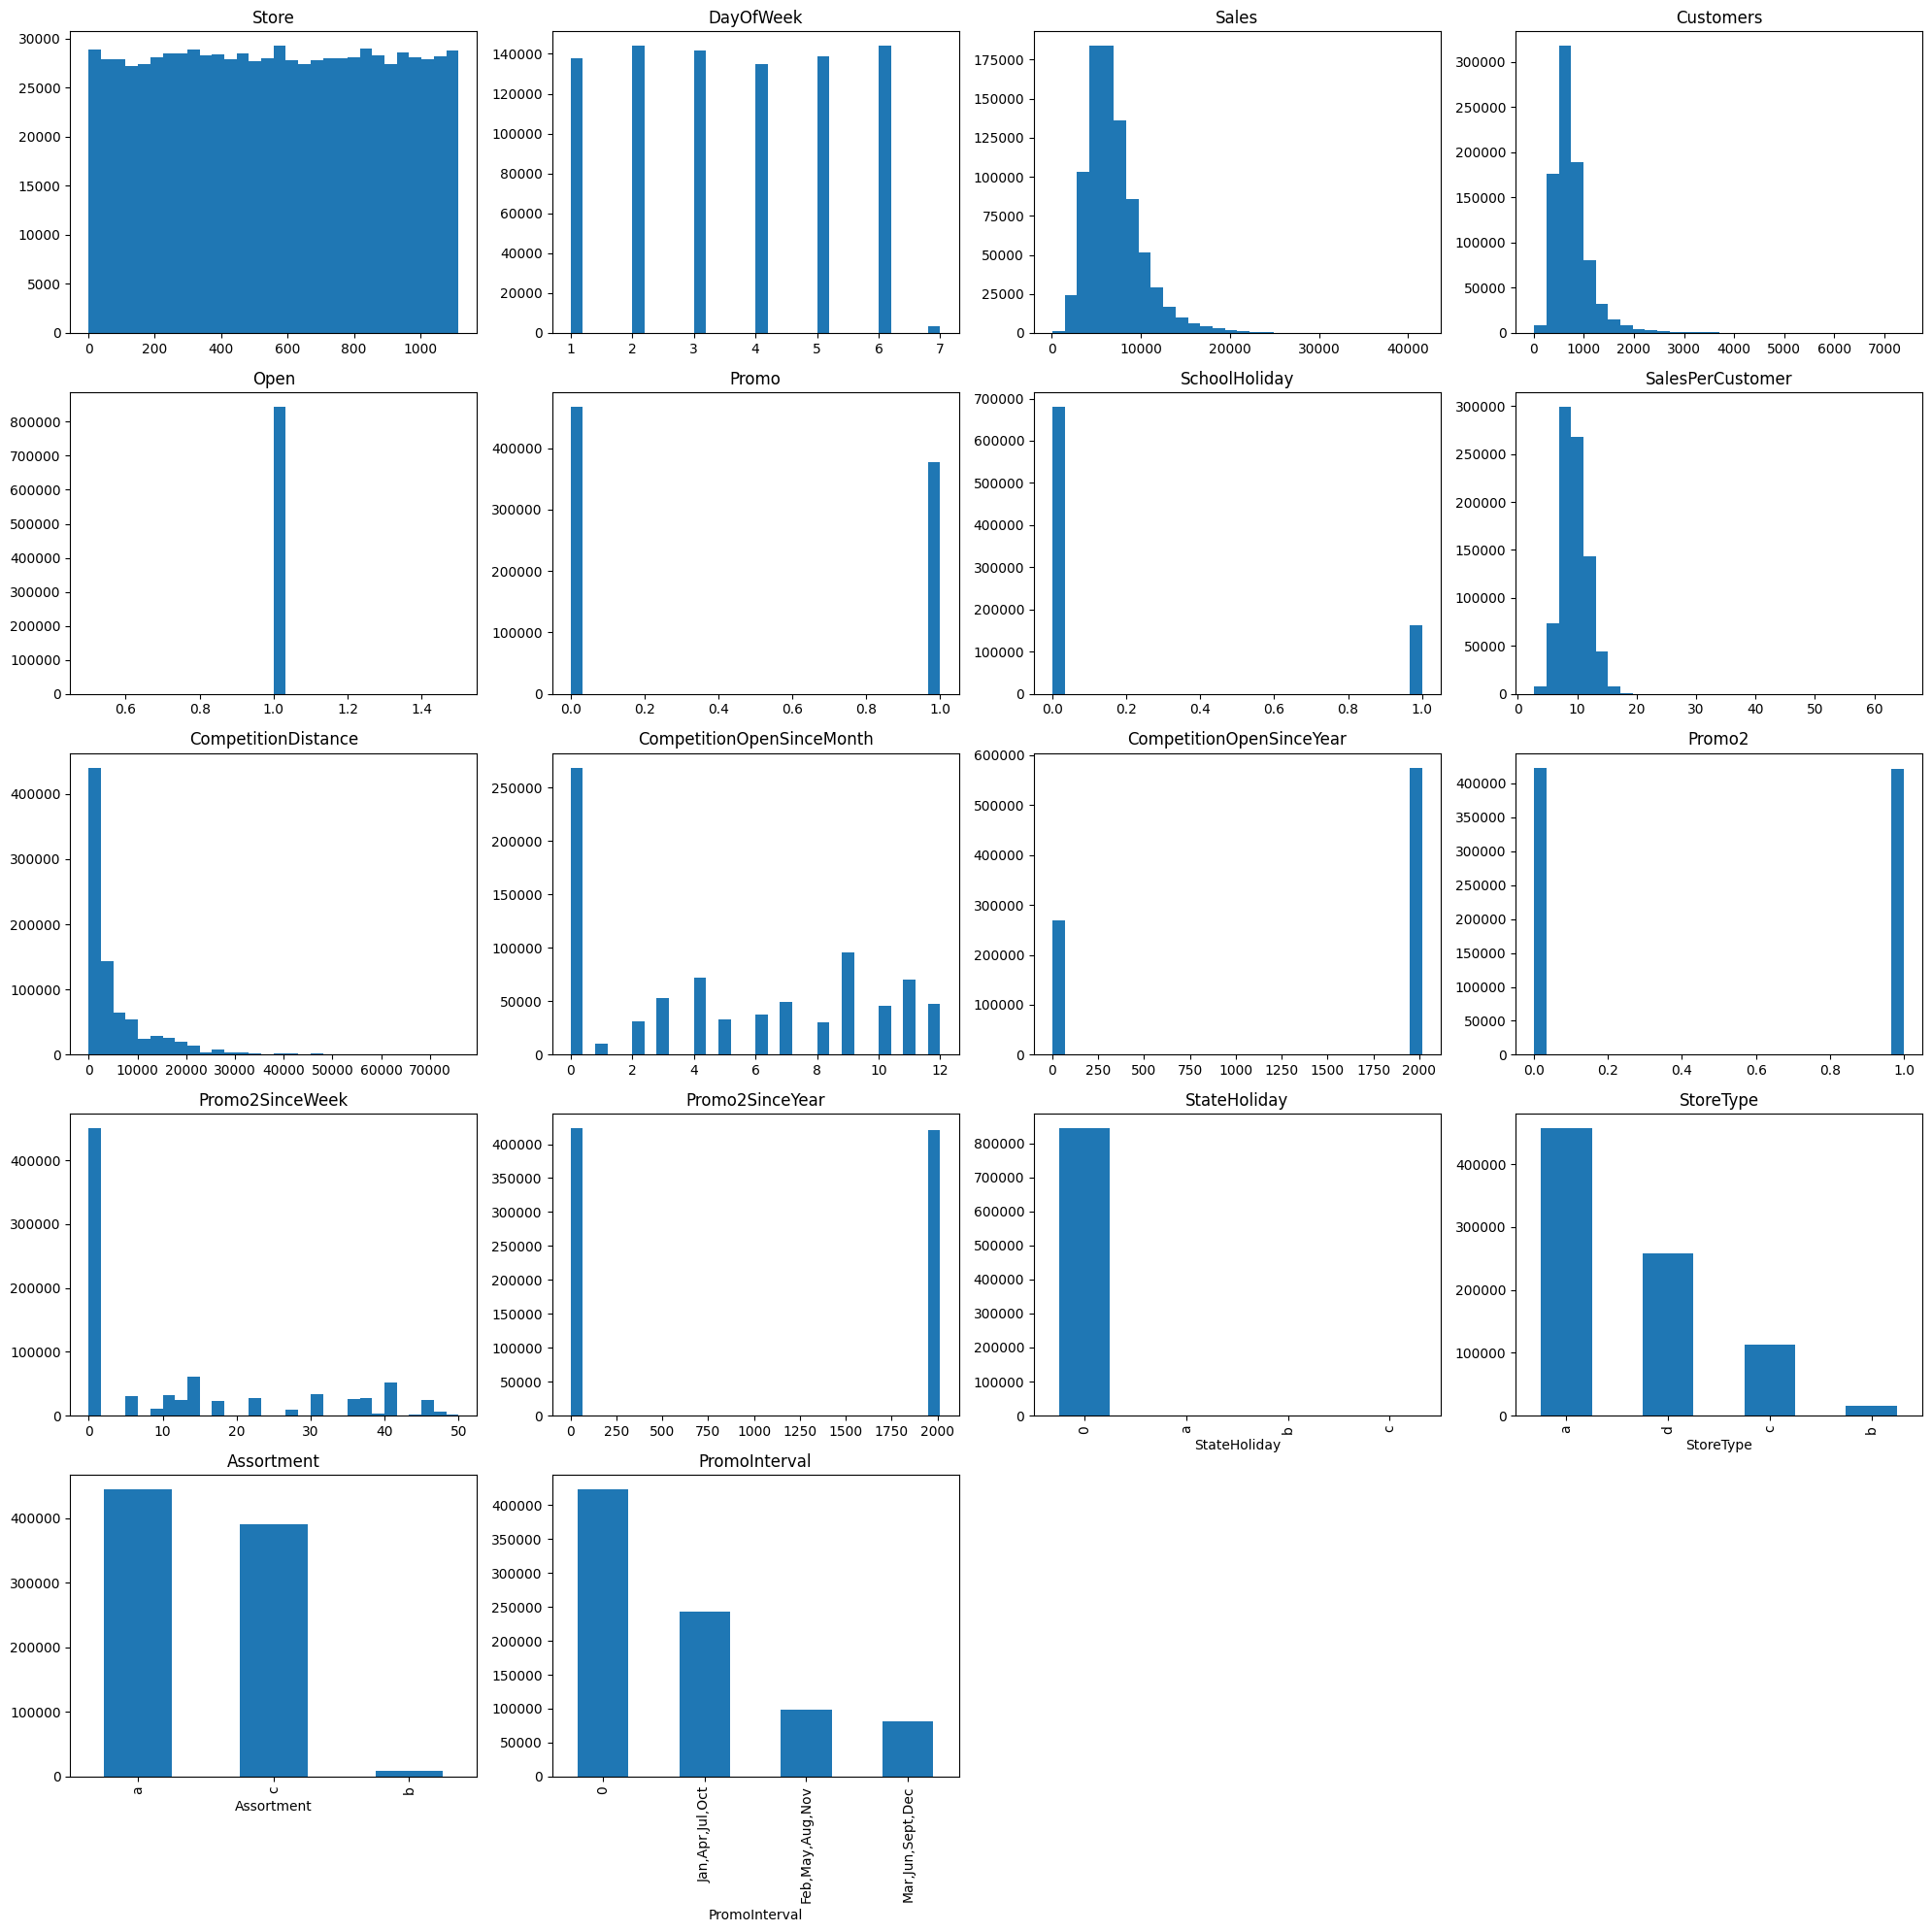

In [ ]:

# Define numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Combine for plotting
all_cols = numeric_cols + categorical_cols

# Set up the grid
n_cols = 4  # number of columns in the plot grid
n_rows = (len(all_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Loop through columns and plot
for i, col in enumerate(all_cols):
    ax = axes[i]
    if col in numeric_cols:
        df[col].hist(bins=30, ax=ax)
        ax.set_title(col)
    else:
        df[col].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(col)
    ax.grid(False)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Used .hist method and .value_counts for looking into the frequency distribuition of all the columns.

1.The dataset is only having the data for open stores day.

2.The sales distribuition is rightly skewed.

3.The frequency of promo day is more than frequency of school holiday.

In [ ]:
#Creating the flag
df["HasCompetition"] = (df["CompetitionOpenSinceYear"] > 0).astype(int)
df["HasPromo2"] = (df["Promo2"] == 1).astype(int)


In [ ]:
features = [
    "Store",
    "DayOfWeek", "Day", "Month", "Year",
    "Open", "Promo", "Promo2",
    "SchoolHoliday", "StateHoliday",
    "StoreType", "Assortment",
    "CompetitionDistance",
    "CompetitionOpenSinceMonth",
    "CompetitionOpenSinceYear",
    "Promo2SinceWeek",
    "Promo2SinceYear","HasCompetition","HasPromo2"
]


In [ ]:
df_model = df.drop(columns=[
    "Sales",
    "Customers",
    "SalesPerCustomer",
    "Date",
    "PromoInterval"
])


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Open                       844338 non-null  int64  
 3   Promo                      844338 non-null  int64  
 4   StateHoliday               844338 non-null  object 
 5   SchoolHoliday              844338 non-null  int64  
 6   Day                        844338 non-null  int32  
 7   Month                      844338 non-null  int32  
 8   Year                       844338 non-null  int32  
 9   StoreType                  844338 non-null  object 
 10  Assortment                 844338 non-null  object 
 11  CompetitionDistance        844338 non-null  float64
 12  CompetitionOpenSinceMonth  844338 non-null  float64
 13  CompetitionOpenSinceYear   84

In [ ]:
df_encoded = pd.get_dummies(
    df_model,
    columns=["StateHoliday", "StoreType", "Assortment"],
    drop_first=True
)


In [ ]:
df_encoded.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,Day,Month,Year,CompetitionDistance,CompetitionOpenSinceMonth,...,HasCompetition,HasPromo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,1,5,1,1,1,31,7,2015,1270.0,9.0,...,1,0,False,False,False,False,True,False,False,False
1,2,5,1,1,1,31,7,2015,570.0,11.0,...,1,1,False,False,False,False,False,False,False,False
2,3,5,1,1,1,31,7,2015,14130.0,12.0,...,1,1,False,False,False,False,False,False,False,False
3,4,5,1,1,1,31,7,2015,620.0,9.0,...,1,0,False,False,False,False,True,False,False,True
4,5,5,1,1,1,31,7,2015,29910.0,4.0,...,1,0,False,False,False,False,False,False,False,False


In [ ]:
#Defining X and y
X = df_encoded
y = df['Sales']


In [ ]:
#Time based train/validation split
train_mask = X["Year"] < 2015

X_train = X[train_mask]
X_val   = X[~train_mask]

y_train = y[train_mask]
y_val   = y[~train_mask]


Modeling Approach:

Models Tried:

Linear Regression → baseline model

Random Forest Regressor → handles non-linear relationships and feature interactions

XGBoost Regressor → gradient boosting, sequentially improves predictions, regularization prevents overfitting

Why Random Forest & XGBoost:

Both can capture complex, non-linear relationships between sales and features such as promotions, competition, and store type.

Random Forest provided a strong baseline (RMSE ~1412).

XGBoost performed best (RMSE ~1152), making it the final model choice due to its better accuracy and robustness.

Target Log Transformation:

Sales data is highly skewed.

Applied log1p transformation (log(1 + Sales)) to:

Stabilize variance across stores and days

Reduce impact of outliers

Improve model focus on overall patterns

Predictions were reverted using np.expm1 to get actual sales values.

Log-transform reduced RMSE and improved prediction accuracy.

Evaluation Metric:

RMSE (Root Mean Squared Error) was used because:

Measures average prediction error in the same units as sales

Penalizes large errors more heavily, which is important for business-critical predictions

Allows direct comparison between models for selection

In [ ]:
# 1.Linear Regression

def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model



In [ ]:
#2.Random Forest Regressor

def train_random_forest(X_train, y_train):
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=30,
        min_samples_leaf=10,
        min_samples_split=20,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model


In [ ]:
#3.XGBoost Regressor(Boosting)

def train_xgboost(X_train, y_train):
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model


RMSE measures average prediction error in sales units

Penalizes large errors

In [ ]:
# Function for calculating RMSE(Root Mean Squared Error)

def evaluate_rmse(model, X_val, y_val, log_target=False):
    """
    Calculates RMSE on validation data.
    If log_target=True, applies inverse log transformation.
    """
    y_pred = model.predict(X_val)

    if log_target:
        y_pred = np.expm1(y_pred)
        y_val  = np.expm1(y_val)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse


In [ ]:
# Log-transform target
y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

# Train models
lr_model  = train_linear_regression(X_train, y_train_log)
rf_model  = train_random_forest(X_train, y_train_log)
xgb_model = train_xgboost(X_train, y_train_log)

# Evaluate
results = {
    "Linear Regression": evaluate_rmse(lr_model, X_val, y_val_log, log_target=True),
    "Random Forest": evaluate_rmse(rf_model, X_val, y_val_log, log_target=True),
    "XGBoost": evaluate_rmse(xgb_model, X_val, y_val_log, log_target=True)
}

for model, rmse in results.items():
    print(f"{model} RMSE: {rmse:.2f}")


Linear Regression RMSE: 2712.92
Random Forest RMSE: 1412.58
XGBoost RMSE: 1152.07


Linear Regression → too simple, underfitting

Random Forest → strong improvement (captures non-linearity)

XGBoost → best model, lowest error

From Linear → XGBoost  error reduced by ~58%

In [ ]:
#Fitting the dataset with XGBoost
def train_xgboost_tuned(X_train, y_train):
    model = XGBRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=10,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=1,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model


In [ ]:
train_rmse = evaluate_rmse(xgb_model, X_train, y_train_log, log_target=True)
val_rmse   = evaluate_rmse(xgb_model, X_val, y_val_log, log_target=True)

print("Train RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)


Train RMSE: 850.6102196159893
Validation RMSE: 1152.070372583285


In [ ]:
#Applying the time series Split for better training

tscv = TimeSeriesSplit(n_splits=3)


I used RandomizedSearchCV with TimeSeriesSplit to tune key XGBoost hyperparameters efficiently. Randomized search allows faster exploration of the hyperparameter space compared to grid search, which is important for large datasets. TimeSeriesSplit ensures that the model is always trained on past data and validated on future data, preventing data leakage. I used RMSE as the evaluation metric because it measures prediction error in actual sales units and penalizes large errors, which is critical for business forecasting.

In [ ]:
#Hyperparameter tuning using Randomized search

param_dist = {
    "max_depth": randint(6, 9),
    "learning_rate": uniform(0.03, 0.05),
    "n_estimators": randint(500, 800),
    "subsample": uniform(0.75, 0.2),
    "colsample_bytree": uniform(0.75, 0.2)
}

xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=15,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train_log)



Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamm...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x783d6c70f3b0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x783d6e14b710>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x783d6eabb500>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x783d6e51fbf0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

Explanation :

max_depth → Controls model complexity (prevents overfitting)

learning_rate → Controls how fast the model learns

n_estimators → Number of boosting trees

subsample → Uses a fraction of rows to reduce overfitting

colsample_bytree → Uses a fraction of features to improve generalization

➡️ These parameters directly impact bias–variance tradeoff.

In [ ]:
#Capturing the best model
best_model = random_search.best_estimator_

train_rmse = evaluate_rmse(best_model, X_train, y_train_log, log_target=True)
val_rmse   = evaluate_rmse(best_model, X_val, y_val_log, log_target=True)

print("Train RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)


Train RMSE: 686.8686373558681
Validation RMSE: 1077.7068927580012


In [ ]:


feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance.head(10)


,feature,importance
3,Promo,0.180718
8,CompetitionDistance,0.178934
0,Store,0.143686
1,DayOfWeek,0.080132
10,CompetitionOpenSinceYear,0.072318
9,CompetitionOpenSinceMonth,0.068901
12,Promo2SinceWeek,0.043824
6,Month,0.038907
13,Promo2SinceYear,0.038763
5,Day,0.037233


Key Findings from Feature Importance

1️⃣ Competition Distance (≈ 20%)

“The most important feature is Competition Distance, which shows that the proximity of competitors has a strong impact on store sales. Stores located closer to competitors tend to experience different sales behavior compared to isolated stores.”

2️⃣ Store ID (≈ 16%)

“Store itself is a significant factor, indicating that each store has unique sales patterns influenced by location, customer base, and operational differences.”

3️⃣ Promo (≈ 15%)

“Promotional campaigns play a major role in driving sales. This confirms that discounts and promotions are one of the strongest levers in retail revenue generation.”

4️⃣ Competition Open Since Year & Month (≈ 15% combined)

“The duration for which a competitor has been active affects sales. New competitors impact sales differently compared to long-established ones.”

5️⃣ Day of Week (≈ 7%)

“Sales vary across weekdays, showing clear weekly purchasing patterns in customer behavior.”

6️⃣ Calendar Features – Month and Day (≈ 9%)

“Seasonality also influences sales. Monthly and daily trends capture fluctuations caused by holidays, seasonal demand, and shopping habits.”

7️⃣ Promo2 Timing (≈ 7%)

“Long-term promotions such as Promo2 also contribute to sales, but with less impact compared to short-term promotions.”

Overall, the results show that competition factors, promotions, and time-based features are the strongest drivers of sales. This aligns well with real-world retail behavior, validating the model’s reliability.

In [ ]:
#Applying the model to the  entire dataset
X_full = df_encoded
y_full_log = np.log1p(df['Sales'])

final_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=10,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=2,
    reg_lambda=2,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_full, y_full_log)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
val_rmse   = evaluate_rmse(final_model, X_full, y_full_log, log_target=True)
val_rmse

np.float64(971.2287742144093)

In [ ]:
#Preprocessing the Test Dataset
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Day'] = test_df['Date'].dt.day
test_df['DayOfWeek'] = test_df['Date'].dt.dayofweek + 1

# Merge store info
X_test = test_df.merge(store_df, on="Store", how="left")

# Fill missing values same as training
#X_test['CompetitionDistance'].fillna(train_df['CompetitionDistance'].median(), inplace=True)
X_test['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
X_test['CompetitionOpenSinceYear'].fillna(0, inplace=True)
X_test['Promo2SinceWeek'].fillna(0, inplace=True)
X_test['Promo2SinceYear'].fillna(0, inplace=True)

#Creating the flag
X_test["HasCompetition"] = (X_test["CompetitionOpenSinceYear"] > 0).astype(int)
X_test["HasPromo2"] = (X_test["Promo2"] == 1).astype(int)

In [ ]:
#Encoding the categoricalvariables in the test dataset
df_final = pd.get_dummies(
    X_test,
    columns=["StateHoliday", "StoreType", "Assortment"],
    drop_first=True
)

df_final = df_final[X_full.columns]


In [ ]:

# Train Final XGBoost Model
# ---------------------------
final_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=10,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=2,
    reg_lambda=2,
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

final_model.fit(X, y_full_log)

# ---------------------------
#  Predict on Test Data
# ---------------------------
y_test_log_pred = final_model.predict(df_final)
y_test_pred = np.expm1(y_test_log_pred)  # reverse log-transform

# ---------------------------
# Save Predictions
# ---------------------------
prediction = pd.DataFrame({
    "Store": test_df["Store"],
    "Sales": y_test_pred
})

In [ ]:
prediction.head()

,Store,Sales
0,1,5908.100586
1,2,6541.880859
2,3,8977.256836
3,4,11540.025391
4,5,6360.966797


In [ ]:
prediction.to_csv("rossmann_test_predictions.csv", index=False)

**Rossmann Store Sales Prediction – Portfolio Summary**

I built a predictive model to forecast daily sales for Rossmann stores using historical sales, store information, promotions, and competition data. I performed extensive data preprocessing and feature engineering, including creating date features, flags for promotions and competition, and one-hot encoding categorical variables. I trained and compared multiple models, including Linear Regression, Random Forest, and XGBoost, with XGBoost achieving the best performance due to its ability to capture complex non-linear relationships and interactions between features.

To handle skewed sales data, I applied a log transformation on the target variable, which stabilized variance and reduced the impact of outliers, improving predictive accuracy. I evaluated models using RMSE, which measures average prediction error in the same units as sales and penalizes large errors. The final XGBoost model was trained on the full dataset and used to generate sales predictions for the test set, with results ready for submission.